<a href="https://colab.research.google.com/github/kriaz100/deep-learning-with-python-notebooks/blob/master/chapter11_part03_transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is a companion notebook for the book [Deep Learning with Python, Second Edition](https://www.manning.com/books/deep-learning-with-python-second-edition?a_aid=keras&a_bid=76564dff). For readability, it only contains runnable code blocks and section titles, and omits everything else in the book: text paragraphs, figures, and pseudocode.

**If you want to be able to follow what's going on, I recommend reading the notebook side by side with your copy of the book.**

This notebook was generated for TensorFlow 2.6.

## The Transformer architecture

Transformers are based on the simple mechanism of ***neural attention***. 

### Understanding self-attention
The idea behind "attention" is that some input features (e.g. some word tokens) are more important than others. The model pays more attention to some features and less to others.

Two examples from other contexts are:
- Max pooling in convnets: keep some features and discard the rest

- TF-IDF normalization: assign importance scores to word tokens.

#### Generalized self-attention: the query-key-value model
The terminology **query**, **key**, and **Value** comes from search algorithms. Suppose you want to query your collection of photos for "*dog on the beach*."

Each of your photoes has been annotated so that it has some **keys** associated with it, depending on the objects in the pictures [pic-1: beach, boat, tree; pic-2: beach, tree, dog; pic-3: dog]


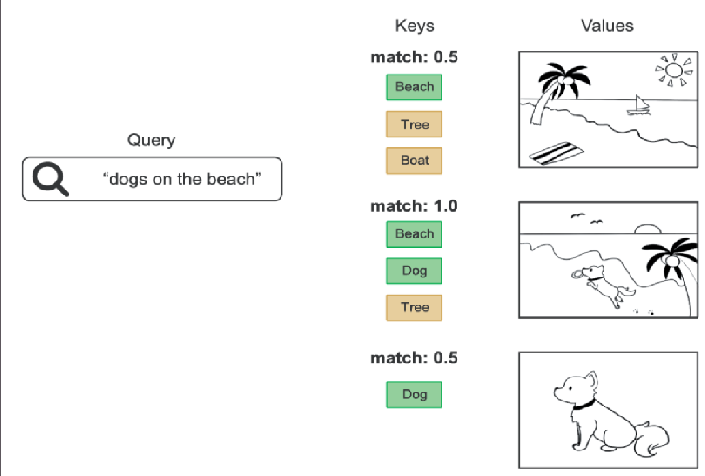

Based on the keys, we can assess to what extent the picture matches the original querry (*dog on the beach*"), which has two word vectors (dog, and beach).

This is done by assigning scores to each picture in the collection depending the closeness of the match. These scores are **values** as shown in the image in the above cell. For example the top an dthe bottom pictures have a score of 0.5 because only one word vector from the query matches the keys. The middle picture has a score of 1.0 because both word vectors match the keys. This is indeed picture of a *dog on the beach*.

### Multi-head attention
- The term "multi-head" implies that the output space of the self-attention layer is factored into a set of independent **sub-spaces**, learned separately. Each sub-space is called a **head**.

- This is similar in principle to how the *depthwise separable convolutions* work where the output space of the convolution is factored into many sub-spaces: *one for each channel* (RGB, for example). 

- Each sub-space gets learned separately. That is, the initial query, key, and value are sent through 3 independent sets of dense projections that result in 3 sets of modulated queries, keys, and values (see the graphic below). Each set is processed through neural attention, and the tree outputs are concatenated back together into a single output.  

-



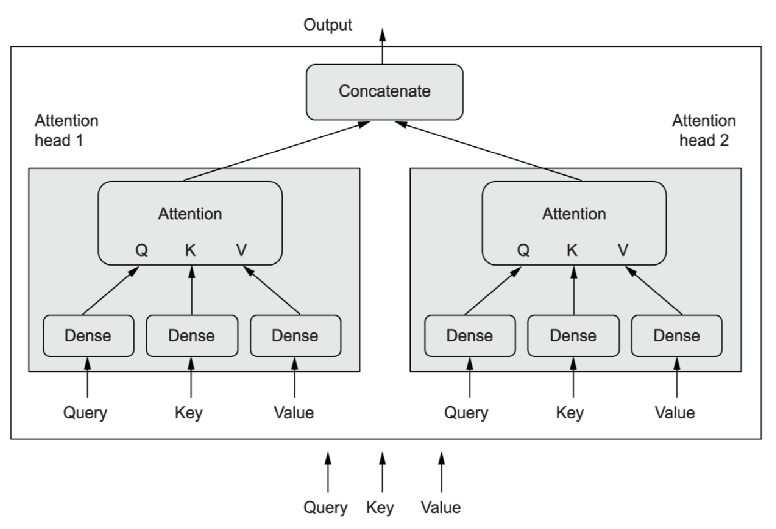

### The Transformer encoder


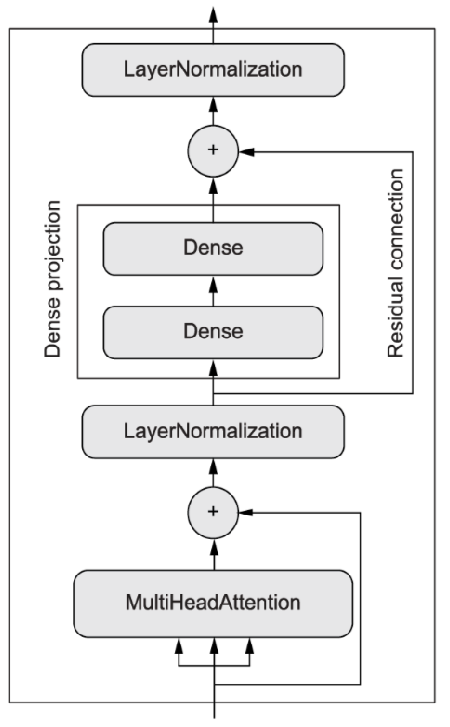

**Getting the data**

We download IMDB data, ad unzip it.
Also remove the unsupported directory named 'unsup' (!rm -r command)

In [ ]:
!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz
!rm -r aclImdb/train/unsup

**The data preparation workflow below is similar to the workflow in book section 11.3.1** (Preparing the IMDB movie reviews data). 

We are just re-using it here (<font color='blue'>see notebook chapter11_part01_introduction</font>).

Also see section notebook chapter11_part01_introduction for `lambda function` toy example and `map()` method. See the notebook sub-section on *Processing words as a set: The bag-of-words approach*

**Preparing the data**

1. We downloaded data, which has the following directory structure:


>>```
aclImdb/train/pos
aclImdb/train/neg
aclImdb/test/pos
aclImdb/test/neg/
>>```

2. We want to create a **validation directory** alongwith subdirectories `val/pos` and `val/neg` 
    
    - Split the training data 80:2 in `train/pos` and `train/neg`

    - Shuffle data in both these subdirectories
    
    - Move 20% data each training subdirectory to, respectively, `val/pos` and `val/neg` 


3. Use Keras utility `text_dataset_from_directory` to create batched dataset of text files and their labels for a directory structure.



In [ ]:
import os, pathlib, shutil, random
from tensorflow import keras

# defining batch size
batch_size = 32

# Creating file path for validation directory
#   and its subdirectories /pos and /neg
#   adding 'exist_ok= True'  argument on os.makedirs(), in case directory exists

base_dir = pathlib.Path("aclImdb")
val_dir = base_dir / "val"
train_dir = base_dir / "train"
for category in ("neg", "pos"):
    os.makedirs(val_dir / category, exist_ok=True)  #adding 'exist_ok=True'  
    files = os.listdir(train_dir / category)
    random.Random(1337).shuffle(files)
    num_val_samples = int(0.2 * len(files))
    val_files = files[-num_val_samples:]
    for fname in val_files:
        shutil.move(train_dir / category / fname,
                    val_dir / category / fname)

# Using Keras utility text_dataset_from_directory to created batches of data 
#   of selected size for each of the /train, /val and /test directories.

train_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/train", batch_size=batch_size
)
val_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/val", batch_size=batch_size
)
test_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/test", batch_size=batch_size
)

# Using lambda function and map() method
#     to put together training data(x) with their labels(y)

text_only_train_ds = train_ds.map(lambda x, y: x)

**Vectorizing the data**

In [ ]:
from tensorflow.keras import layers

max_length = 600
max_tokens = 20000
text_vectorization = layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=max_length,
)
text_vectorization.adapt(text_only_train_ds)

int_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

**Transformer encoder implemented as a subclassed `Layer`**

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# TransformerEncoder class is defined that inherits from layers.Layer
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"),
             layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()

    def call(self, inputs, mask=None):
        if mask is not None:
            mask = mask[:, tf.newaxis, :]
        attention_output = self.attention(
            inputs, inputs, attention_mask=mask)
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config

**Using the Transformer encoder for text classification**

In [ ]:
vocab_size = 20000
embed_dim = 256
num_heads = 2
dense_dim = 32

inputs = keras.Input(shape=(None,), dtype="int64")
x = layers.Embedding(vocab_size, embed_dim)(inputs)
x = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

**Training and evaluating the Transformer encoder based model**

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint("transformer_encoder.keras",
                                    save_best_only=True)
]
model.fit(int_train_ds, validation_data=int_val_ds, epochs=20, callbacks=callbacks)
model = keras.models.load_model(
    "transformer_encoder.keras",
    custom_objects={"TransformerEncoder": TransformerEncoder})
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

#### Using positional encoding to re-inject order information

**Implementing positional embedding as a subclassed layer**

In [ ]:
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, input_dim, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=input_dim, output_dim=output_dim)
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=output_dim)
        self.sequence_length = sequence_length
        self.input_dim = input_dim
        self.output_dim = output_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)

    def get_config(self):
        config = super().get_config()
        config.update({
            "output_dim": self.output_dim,
            "sequence_length": self.sequence_length,
            "input_dim": self.input_dim,
        })
        return config

#### Putting it all together: A text-classification Transformer

**Combining the Transformer encoder with positional embedding**

In [ ]:
vocab_size = 20000
sequence_length = 600
embed_dim = 256
num_heads = 2
dense_dim = 32

inputs = keras.Input(shape=(None,), dtype="int64")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(inputs)
x = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

callbacks = [
    keras.callbacks.ModelCheckpoint("full_transformer_encoder.keras",
                                    save_best_only=True)
]
model.fit(int_train_ds, validation_data=int_val_ds, epochs=20, callbacks=callbacks)
model = keras.models.load_model(
    "full_transformer_encoder.keras",
    custom_objects={"TransformerEncoder": TransformerEncoder,
                    "PositionalEmbedding": PositionalEmbedding})
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

### When to use sequence models over bag-of-words models?